In [1]:
import numpy as np

class StochasticEnv:

    def __init__(self, n_arms, sigma):
        self.n_arms = n_arms
        self.sigma = sigma
        self.reset(0)
        
    def step(self, action):
        return self.expected[action] + np.random.normal(0, self.sigma, 1)

    def reset(self, i_trials):
        self.expected = np.random.uniform(0, 1, self.n_arms)
    
    def get_exp_values(self):
        return self.expected

In [2]:
logplus = lambda x : np.log(np.maximum(1, x))

class UCBAgent:
    
    def __init__(self, n_arms, sigma, bound='ucb1', alpha=None, horizon=None):
        assert bound=='ucb1' or bound=='moss', 'error in upper confidence bound selection'
        if bound=='moss':
            assert horizon is not None, 'moss is not anytime, please select an horizon'
            self.horizon = horizon
        if bound=='ucb1':
            assert alpha is not None, 'ucb1 requires hyperparameter alpha'
            self.alpha = alpha
        self.n_arms = n_arms
        self.sigma = sigma
        self.bound = bound
        self.reset()

    def reset(self):
        self.t = 1
        self.last_pull = None
        self.avg_reward = np.zeros(self.n_arms)
        self.n_pulls = np.zeros(self.n_arms)
        return self

    def pull_arm(self):
        if self.bound=='ucb1':
            ucb = self.avg_reward + self.sigma * np.sqrt(
                       self.alpha * np.log(self.t) / self.n_pulls)
        if self.bound=='moss':    
            ucb = self.avg_reward + self.sigma * np.sqrt((4 / self.n_pulls) * logplus(
                       self.horizon / (self.n_arms * self.n_pulls))) 
        self.last_pull = np.argmax(ucb)
        return self.last_pull

    def update(self, reward):
        self.t += 1
        self.avg_reward[self.last_pull] = (self.avg_reward[self.last_pull] *
            self.n_pulls[self.last_pull] + reward) / (self.n_pulls[self.last_pull] + 1)
        self.n_pulls[self.last_pull] += 1

  0%|          | 0/10 [00:00<?, ?it/s]

/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_20069/1220251987.py:28: RuntimeWarning: invalid value encountered in true_divide
  self.alpha * np.log(self.t) / self.n_pulls)
/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_20069/1220251987.py:30: RuntimeWarning: divide by zero encountered in true_divide
  ucb = self.avg_reward + self.sigma * np.sqrt((4 / self.n_pulls) * logplus(
/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_20069/1220251987.py:31: RuntimeWarning: divide by zero encountered in true_divide
  self.horizon / (self.n_arms * self.n_pulls)))
/var/folders/lg/fmb0kjh9645f_jx1v2_gjsh40000gn/T/ipykernel_20069/1220251987.py:28: RuntimeWarning: divide by zero encountered in true_divide
  self.alpha * np.log(self.t) / self.n_pulls)


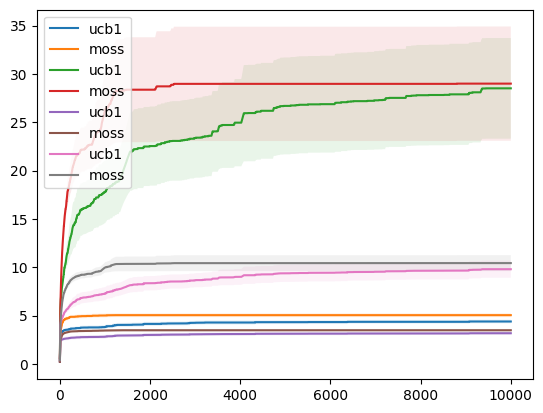

In [3]:
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
np.set_printoptions(formatter={'float': lambda x: "{0:0.02f}".format(x)})

ucb1 = '\\ucbone'
moss = '\\moss'

horizon = 10000
n_trials = 10
sigma = 0.1
n_arms = 10

env = StochasticEnv(n_arms, sigma)

ucb1agent = UCBAgent(n_arms, sigma, bound='ucb1', alpha=2)
mossagent = UCBAgent(n_arms, sigma, bound='moss', horizon=horizon)

actions_ucb1 = np.zeros((n_trials, horizon))
actions_moss = np.zeros((n_trials, horizon))

expectedreward_ucb1 = np.zeros((n_trials, horizon))
expectedreward_moss = np.zeros((n_trials, horizon))

expectedregret_ucb1 = np.zeros((n_trials, horizon))
expectedregret_moss = np.zeros((n_trials, horizon))

max_expected = np.zeros(n_trials)

for sim_i in tqdm(range(n_trials)):
    
    env.reset(sim_i)
    expected = env.get_exp_values()
    max_expected[sim_i] = max(expected)
    ucb1agent.reset()
    mossagent.reset()

    for t in range(horizon):
        
        action = ucb1agent.pull_arm()
        reward = env.step(action)
        ucb1agent.update(reward)
        actions_ucb1[sim_i, t] = action
        expectedreward_ucb1[sim_i, t] = expected[action]
        
        action = mossagent.pull_arm()
        reward = env.step(action)
        mossagent.update(reward)
        actions_moss[sim_i, t] = action
        expectedreward_moss[sim_i, t] = expected[action]
    
    expectedregret_ucb1[sim_i, :] = max_expected[sim_i] - expectedreward_ucb1[sim_i, :]
    expectedregret_moss[sim_i, :] = max_expected[sim_i] - expectedreward_moss[sim_i, :]

exp_ottima = lambda x : np.maximum(0, x - 0.1) 
sqrtfun = lambda x : np.sqrt(x) 
power2 = lambda x : np.power(x, 2) 
identity = lambda x : x
funcs = [exp_ottima, sqrtfun, power2, identity]

for func in funcs:
    
    expectedregret_ucb1_g = func(expectedregret_ucb1)
    expectedregret_moss_g = func(expectedregret_moss)
    
    cum_expectedregret_ucb1 = expectedregret_ucb1_g.cumsum(axis=1)
    cum_expectedregret_moss = expectedregret_moss_g.cumsum(axis=1)
    
    cum_expectedregret_ucb1_mean = cum_expectedregret_ucb1.mean(axis=0)
    cum_expectedregret_moss_mean = cum_expectedregret_moss.mean(axis=0)
    
    cum_expectedregret_ucb1_std = cum_expectedregret_ucb1.std(axis=0) / np.sqrt(n_trials)
    cum_expectedregret_moss_std = cum_expectedregret_moss.std(axis=0) / np.sqrt(n_trials)
    
    plt.plot(cum_expectedregret_ucb1_mean.T, label='ucb1')
    plt.fill_between(np.linspace(0, horizon-1, horizon), 
                     cum_expectedregret_ucb1_mean - cum_expectedregret_ucb1_std,
                     cum_expectedregret_ucb1_mean + cum_expectedregret_ucb1_std, alpha=0.1)
    plt.plot(cum_expectedregret_moss_mean.T, label='moss')
    plt.fill_between(np.linspace(0, horizon-1, horizon), 
                     cum_expectedregret_moss_mean - cum_expectedregret_moss_std,
                     cum_expectedregret_moss_mean + cum_expectedregret_moss_std, alpha=0.1)
    plt.legend()